In [1]:
import torch
from src.checkpoint import Checkpoint

experiment = Checkpoint.load("../experiments/TDVAE40_migrate/migration/2023-09-23__16-22/migrated_checkpoint.pth")
model = experiment.get_model()

In [23]:
from src.hvae.model import compute_loss

target_block = "y"

kl_scaler = 0

def operation_target(x):
    computed, distributions = model(x, use_mean=True)
    return computed[target_block]

def operation(target_unit):
    def op(x):
        #x.to("cpu")
        computed, distributions = model(x, use_mean=True)
        losses = compute_loss(x, distributions)
        to_query = torch.flatten(computed[target_block], start_dim=1)
        to_add = -losses["kl_div"] * kl_scaler
        loss = torch.mean(to_query[:, target_unit], dim=0) + to_add
        return -loss
    return op

In [3]:
from meitorch.mei import MEI

In [47]:
receptive_fields = MEI.white_noise_analysis(operation=operation_target, shape=(1, 40, 40), n_samples=1_000_000, sigma=0.1)

In [19]:
texture_dims = [110]#[91, 86, 110, 11, 225]
non_texture_dims = [214]#[214, 163, 223, 10, 219]

In [ ]:
from matplotlib.pyplot import figure, savefig
import numpy as np

def plot_wna(units, save=None):
    fig = figure(figsize=(10, 3))
    for n, i in enumerate(units):
        ax = fig.add_subplot(1, 5, n + 1)
        ax.imshow(receptive_fields[i, ...].reshape(40, 40))
        ax.set_title(f"Unit {i}")
        ax.axis("off")
    if save:
        savefig(save)

plot_wna(texture_dims, save="y_textutre_decoding_wna.png")
plot_wna(non_texture_dims, save="y_non_textutre_encoding_wna.png")
np.save("y_receptive_fields_1m.npy", receptive_fields)

In [5]:
from meitorch.tools.schedules import LinearSchedule

In [24]:
image_mei_config = dict(
    iter_n=1000,
    n_samples=1, # number of samples per batch
    save_every=100,        # save image every n iterations
    bias=0,               # bias of the image
    scale=1,              # scaling of the image
    diverse=False,
    diverse_params=dict(),

    #transformations
    scaler=None,              # scaling of the image (float or schedule)
    jitter=2,             # size of translational jittering

    #normalization/clipping
    train_norm=None,        # norm adjustment during step
    norm=None,              # norm adjustment after step
    clip=None,

    #optmizer
    optimizer="mei",
    optimizer_params=dict(
        lr=0.01,        # scaling of gradient steps (float or schedule) = learning rate
        step_size=LinearSchedule(2, 0.125)
    ),

    #preconditioning
    precond=None,            # strength of gradient preconditioning filter falloff (float or schedule)

    #denoiser
    denoiser='gaussian',
    denoiser_params=dict(
        sigma=LinearSchedule(1, 0.01)
        #reguralization_scaler=0.1,
        #lr=0.1,
        #num_iters=100,
    ),
)

100%|██████████| 1000/1000 [00:30<00:00, 32.54it/s]


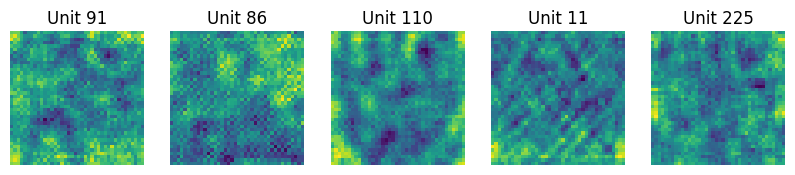

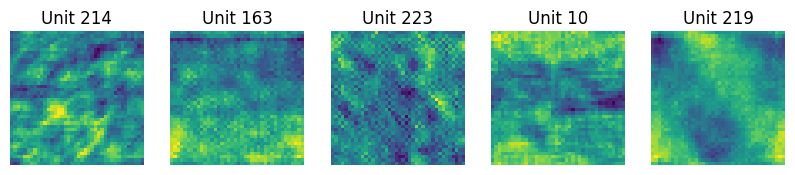

In [99]:
texture_results, non_texture_results = run_config(image_mei_config, save="01_1000_kl_05")

In [25]:
texture_meis = []
non_texture_meis = []
for dim in texture_dims:
    texture_meis.append(MEI(operation=operation(dim), shape=(1, 40, 40)))
for dim in non_texture_dims:
    non_texture_meis.append(MEI(operation=operation(dim), shape=(1, 40, 40)))

In [26]:
texture_results = []
non_texture_results = []

for mei in texture_meis:
    texture_results.append(mei.generate_image_based(**image_mei_config))
for mei in non_texture_meis:
    non_texture_results.append(mei.generate_image_based(**image_mei_config))

100%|██████████| 1000/1000 [00:29<00:00, 33.65it/s]


In [13]:
from matplotlib.pyplot import figure, savefig
import numpy as np

def plot_meis(meis, units, save=None):
    fig = figure(figsize=(10, 3))
    for n, (mei, i) in enumerate(zip(meis, units)):
        ax = fig.add_subplot(1, 5, n + 1)
        image = mei.get_image()[0].detach().numpy()
        ax.imshow(image.reshape(40, 40))
        ax.set_title(f"Unit {i}")
        ax.axis("off")
    if save:
        savefig(save)

#plot_meis(texture_results, texture_dims, save="y_texture_decoding_mei.png")
#plot_meis(non_texture_results, non_texture_dims, save="y_non_texture_decoding_mei.png")

In [14]:
def run_config(config, save=None):

    texture_meis = []
    non_texture_meis = []
    for dim in texture_dims:
        texture_meis.append(MEI(operation=operation(dim), shape=(1, 40, 40)))
    for dim in non_texture_dims:
        non_texture_meis.append(MEI(operation=operation(dim), shape=(1, 40, 40)))

    texture_results = []
    non_texture_results = []

    for mei in texture_meis:
        texture_results.append(mei.generate_variational(**config))
    for mei in non_texture_meis:
        non_texture_results.append(mei.generate_variational(**config))

    plot_meis(texture_results, texture_dims, save=f"y_texture_decoding_{save}.png" if save else None)
    plot_meis(non_texture_results, non_texture_dims, save=f"y_non_texture_decoding_{save}.png" if save else None)
    return texture_results, non_texture_results

In [10]:
texture_meis[0].plot_history()

NameError: name 'texture_meis' is not defined

In [11]:
from matplotlib.pyplot import plot

plot(texture_results[2].loss_history)

NameError: name 'texture_results' is not defined

In [25]:
var_mei_config = dict(
    iter_n=500,
    save_every=100,        # save image every n iterations
    bias=0,               # bias of the image
    scale=1,              # scaling of the image
    diverse=False,
    diverse_params=dict(),

    #transformations
    scaler=None,              # scaling of the image (float or schedule)
    jitter=None,             # size of translational jittering

    #normalization/clipping
    train_norm=None,        # norm adjustment during step
    norm=None,              # norm adjustment after step
    clip=None,

    #optmizer
    optimizer="adam",
    optimizer_params=dict(
        lr=0.01,        # scaling of gradient steps (float or schedule) = learning rate
        #step_size=LinearSchedule(2, 0.125)
    ),

    #preconditioning
    precond=None,            # strength of gradient preconditioning filter falloff (float or schedule)

    #denoiser
    denoiser=None,
    denoiser_params=dict(
        sigma=LinearSchedule(1, 0.01)
        #reguralization_scaler=0.1,
        #lr=0.1,
        #num_iters=100,
    ),

    #variational
    distribution='normal',
    n_samples_per_batch=(128,),
    fixed_stddev=0.4,
)

100%|██████████| 500/500 [00:36<00:00, 13.71it/s]


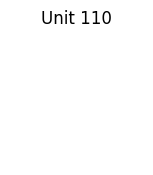

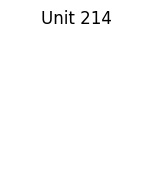

In [26]:
texture_results, non_texture_results = run_config(var_mei_config, save="var_01_10_kl_0")

In [178]:
from meitorch.result import MEI_distibution

def generate_loc_scale(img_shape, fixed_stddev=False):
    mean = generate_random_noise(img_shape)
    mean = torch.nn.Parameter(torch.tensor(mean), requires_grad=True)

    if fixed_stddev:
        std = torch.ones(img_shape) * fixed_stddev
    else:
        std = generate_random_noise(img_shape)
        std = torch.nn.Parameter(torch.tensor(std), requires_grad=True)
    return mean, std

def generate_random_noise(shape):
    # generate initial random image
    background_color = np.float32([0] * 1)
    gen_img = np.random.normal(background_color, 1 / 20, shape)
    gen_img = np.clip(gen_img, -1, 1)
    return gen_img

mean, std = generate_loc_scale((1, 40, 40))
dist = torch.distributions.Normal(mean, std)

In [186]:
class Mod(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mean, self.std = generate_loc_scale((1, 40, 40))
        dist = torch.distributions.Normal(mean, std)
        self.dist = dist

In [187]:
m = Mod()

In [188]:
for param in m.parameters():
    print(param)

Parameter containing:
tensor([[[ 0.0571,  0.0065,  0.0301,  ..., -0.0364,  0.0738, -0.0263],
         [ 0.0821,  0.0334,  0.0804,  ...,  0.0511,  0.0703, -0.0112],
         [ 0.0152, -0.0443, -0.0327,  ...,  0.0380,  0.0621, -0.0053],
         ...,
         [ 0.0557, -0.0864,  0.0173,  ..., -0.0732,  0.0923,  0.0346],
         [ 0.0006,  0.0180, -0.0339,  ...,  0.0387, -0.0109,  0.0812],
         [-0.0079,  0.0855, -0.0351,  ...,  0.0468, -0.0218, -0.1080]]],
       dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[[-0.0442, -0.0431, -0.0833,  ...,  0.0443, -0.0518,  0.0178],
         [-0.0485, -0.0191, -0.0013,  ...,  0.0264, -0.0471, -0.0337],
         [ 0.0323, -0.0467,  0.0663,  ..., -0.0906,  0.0138,  0.0694],
         ...,
         [-0.0140, -0.0264, -0.0532,  ...,  0.0314, -0.0940, -0.0434],
         [-0.0284,  0.0375,  0.0578,  ..., -0.0780, -0.0115,  0.0322],
         [-0.0188, -0.0568,  0.0632,  ..., -0.0315, -0.0016, -0.0729]]],
       dtype=torch.float

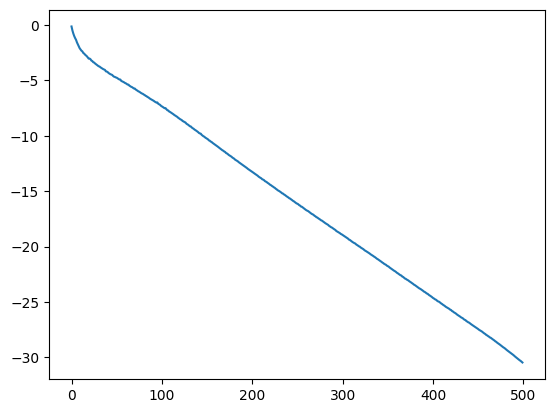

In [22]:
from matplotlib.pyplot import plot
plot(texture_results[0].loss_history)